In [1]:
import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import tensorflow as tf
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

In [2]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def sensitivity(y_true, y_pred):
    # tp/(fn + tp)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tp = y_true_tmp[y_true_tmp == y_pred_tmp]
    tp = len(tp[tp == 1])
    fn = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fn = len(fn[fn == 0])
    try:
        return tp / (tp + fn)
    except ZeroDivisionError:
        return 0.0

def specificity(y_true, y_pred):
    # tn / (fp + tn)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tn = y_true_tmp[y_true_tmp == y_pred_tmp]
    tn = len(tn[tn == 0])
    fp = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fp = len(fp[fp == 1])
    try:
        return tn / (tn + fp)
    except ZeroDivisionError:
        return 0.0

# def balanced_acc(sensitivity, specificity):
#     return (sensitivity + specificity) / 2.0

def balanced_acc(y_true, y_pred):
    return (sensitivity(y_true, y_pred) + specificity(y_true, y_pred)) / 2.0

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (154, 224, 224)
X_test shape: (66, 224, 224)
y_train shape (154,)
y_test shape: (66,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

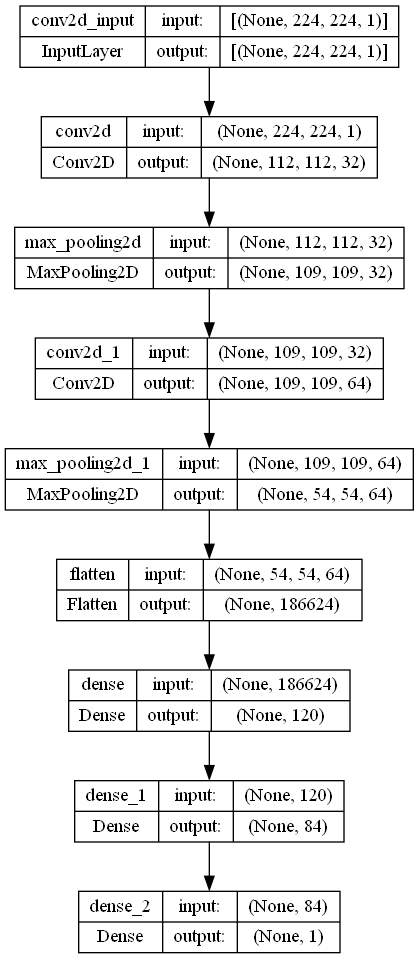

In [5]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

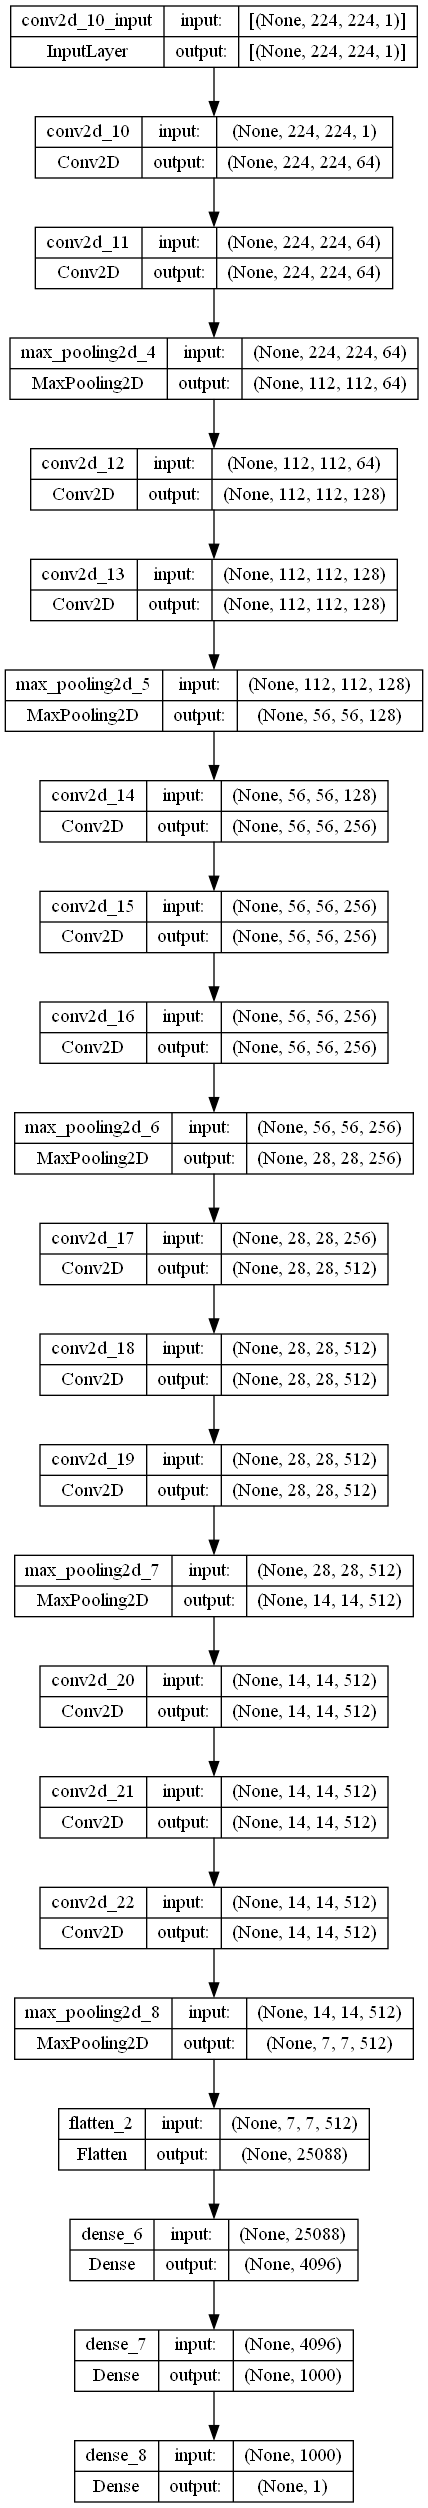

In [7]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=1000, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

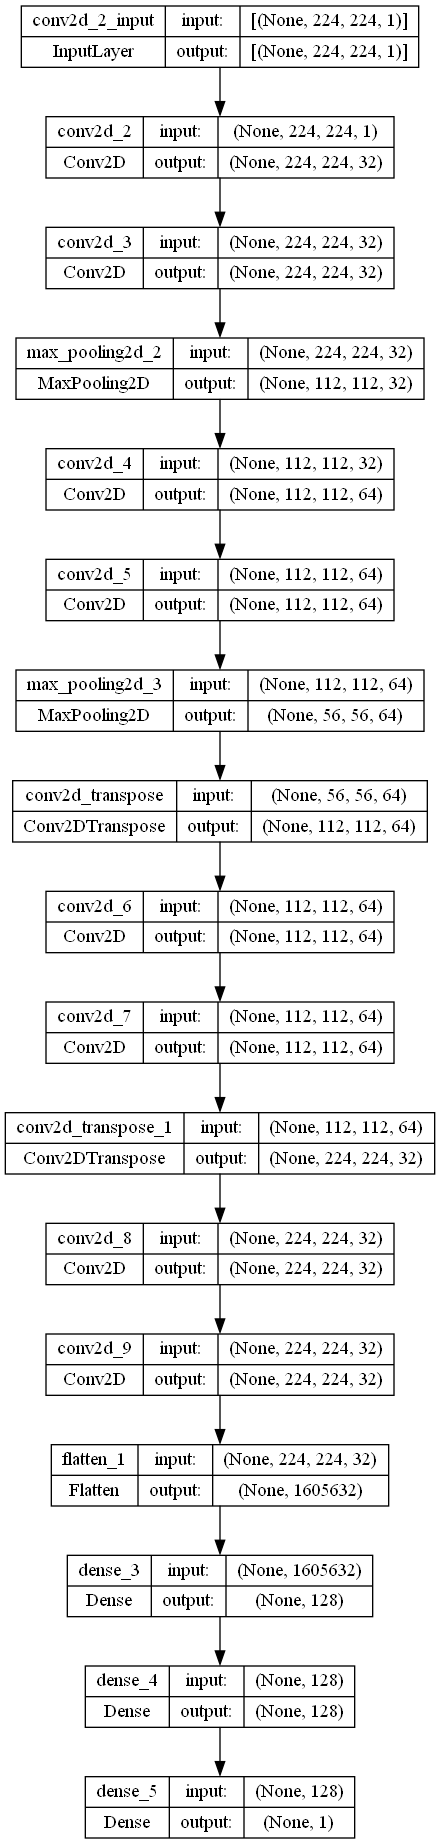

In [6]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dense(units=128, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net.png', show_shapes=True, show_layer_names=True)

In [8]:
#opt = keras.optimizers.Adam(learning_rate=0.0003)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    sensitivity,
    specificity,
    balanced_acc
]

le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [9]:
def fit_evaluate(model, X_train, X_test, y_train, y_test, batch_size=32, epochs=100, validation_split=0.2):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    scores_model = model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics):
    fig, ax = plt.subplots(nrows=1, ncols=len(metrics), sharex=True, figsize=(30, 10))
    for i, metric in zip(range(len(metrics)), metrics):
        ax[i].plot(range(1, 101), df[metric], 'b-', label='Train')
        ax[i].plot(range(1, 101), df[f'val_{metric}'], 'r-', label='Validation')
        ax[i].set_title(metric)
        ax[i].legend()
    plt.show()

In [10]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, y_train, y_test)

c:\Users\kmart\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
4/4 [==============================] - 7s 2s/step - loss: 267.3752 - precision: 0.6703 - binary_accuracy: 0.6098 - recall: 0.7722 - sensitivity: 0.7500 - specificity: 0.2500 - balanced_acc: 0.5000 - val_loss: 27.3015 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.5161 - val_recall: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_balanced_acc: 0.5000
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 13.7989 - precision: 0.5893 - binary_accuracy: 0.4390 - recall: 0.4177 - sensitivity: 0.4750 - specificity: 0.5208 - balanced_acc: 0.4979 - val_loss: 1.0709 - val_precision: 0.4839 - val_binary_accuracy: 0.4839 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_balanced_acc: 0.5000
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 0.6192 - precision: 0.6423 - binary_accuracy: 0.6423 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - balanced_acc: 0.5000 - val_los

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, y_train, y_test)

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 48s 12s/step - loss: 0.7670 - precision: 0.6051 - binary_accuracy: 0.5714 - recall: 0.8333 - sensitivity: 0.7500 - specificity: 0.2500 - balanced_acc: 0.5000 - val_loss: 0.6815 - val_precision: 0.6452 - val_binary_accuracy: 0.6452 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_balanced_acc: 0.5000
Epoch 2/100
4/4 [==============================] - 35s 9s/step - loss: 0.7160 - precision: 0.6016 - binary_accuracy: 0.6016 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - balanced_acc: 0.5000 - val_loss: 0.6550 - val_precision: 0.6452 - val_binary_accuracy: 0.6452 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_balanced_acc: 0.5000
Epoch 3/100
4/4 [==============================] - 35s 9s/step - loss: 0.6854 - precision: 0.6016 - binary_accuracy: 0.6016 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - balanced_acc: 0.5000 - val_loss: 0

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,balanced_acc,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,val_balanced_acc
0,0.766955,0.605096,0.571429,0.833333,0.75,0.25,0.5,0.681498,0.645161,0.645161,1.0,1.0,0.0,0.5
1,0.716046,0.601626,0.601626,1.000000,1.00,0.00,0.5,0.655019,0.645161,0.645161,1.0,1.0,0.0,0.5
2,0.685441,0.601626,0.601626,1.000000,1.00,0.00,0.5,0.691562,0.645161,0.645161,1.0,1.0,0.0,0.5
3,0.693497,0.576271,0.471545,0.459459,0.50,0.50,0.5,0.683318,0.645161,0.645161,1.0,1.0,0.0,0.5
4,0.682180,0.601626,0.601626,1.000000,1.00,0.00,0.5,0.656796,0.645161,0.645161,1.0,1.0,0.0,0.5


In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,balanced_acc,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,val_balanced_acc
0,716.239014,0.673267,0.582011,0.596491,0.5125,0.500000,0.506250,0.786196,0.000000,0.354839,0.0,0.0,1.0,0.5
1,0.952374,0.626374,0.585366,0.770270,0.7500,0.250000,0.500000,0.655255,0.645161,0.645161,1.0,1.0,0.0,0.5
2,0.663311,0.601626,0.601626,1.000000,1.0000,0.000000,0.500000,0.657833,0.645161,0.645161,1.0,1.0,0.0,0.5
3,0.719408,0.621849,0.634146,1.000000,1.0000,0.090909,0.545455,0.694840,0.000000,0.354839,0.0,0.0,1.0,0.5
4,0.694086,0.000000,0.398374,0.000000,0.0000,1.000000,0.500000,0.693249,0.000000,0.354839,0.0,0.0,1.0,0.5


In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,balanced_acc,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,val_balanced_acc
0,435.130798,0.515625,0.414634,0.445946,0.500000,0.500000,0.500000,97.402771,0.000000,0.354839,0.00,0.00,1.000000,0.500000
1,26.955679,0.639344,0.536585,0.527027,0.527778,0.500000,0.513889,0.961578,0.645161,0.645161,1.00,1.00,0.000000,0.500000
2,0.797130,0.603306,0.601626,0.986486,0.984375,0.022727,0.503551,0.648425,0.666667,0.483871,0.40,0.40,0.636364,0.518182
3,0.630790,0.793103,0.674797,0.621622,0.633709,0.768114,0.700911,0.691762,0.666667,0.419355,0.20,0.20,0.818182,0.509091
4,0.641120,0.741935,0.642276,0.621622,0.628289,0.670017,0.649153,0.663049,0.684211,0.580645,0.65,0.65,0.454545,0.552273


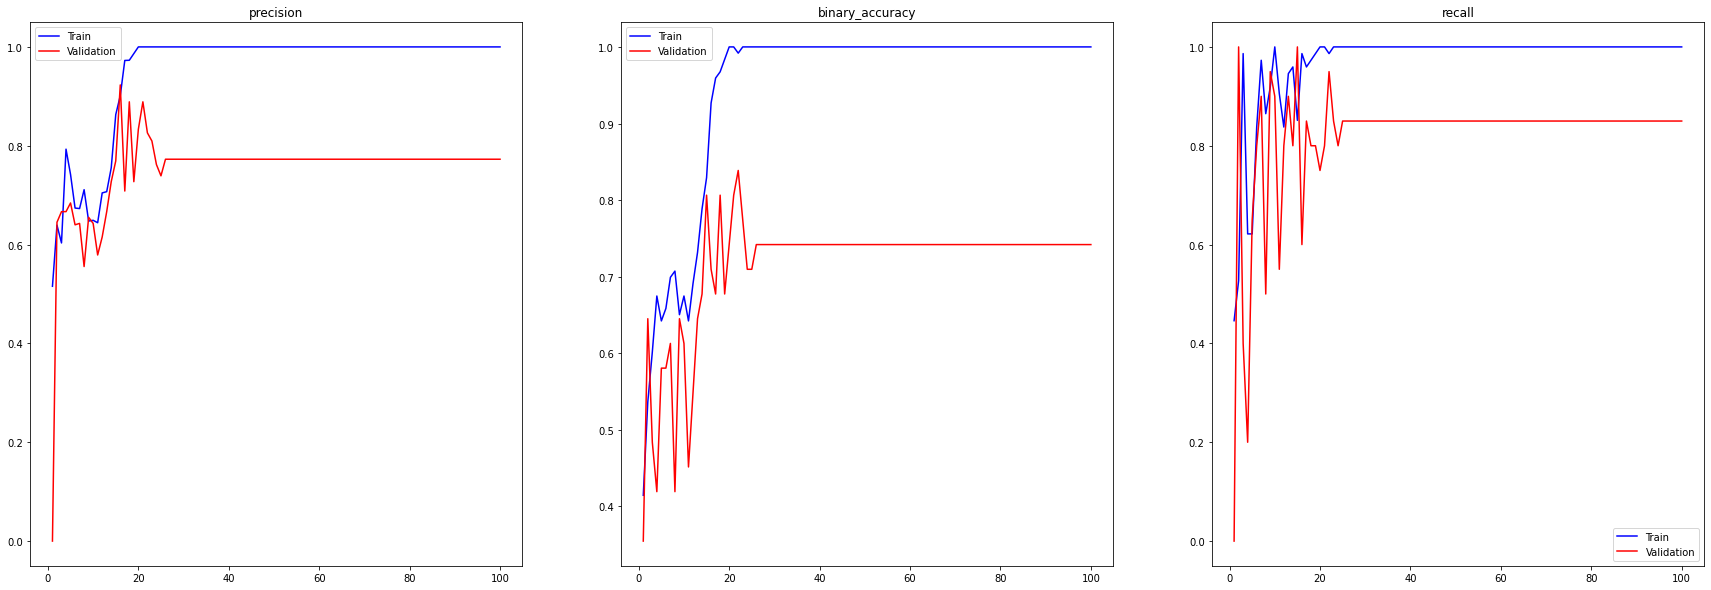

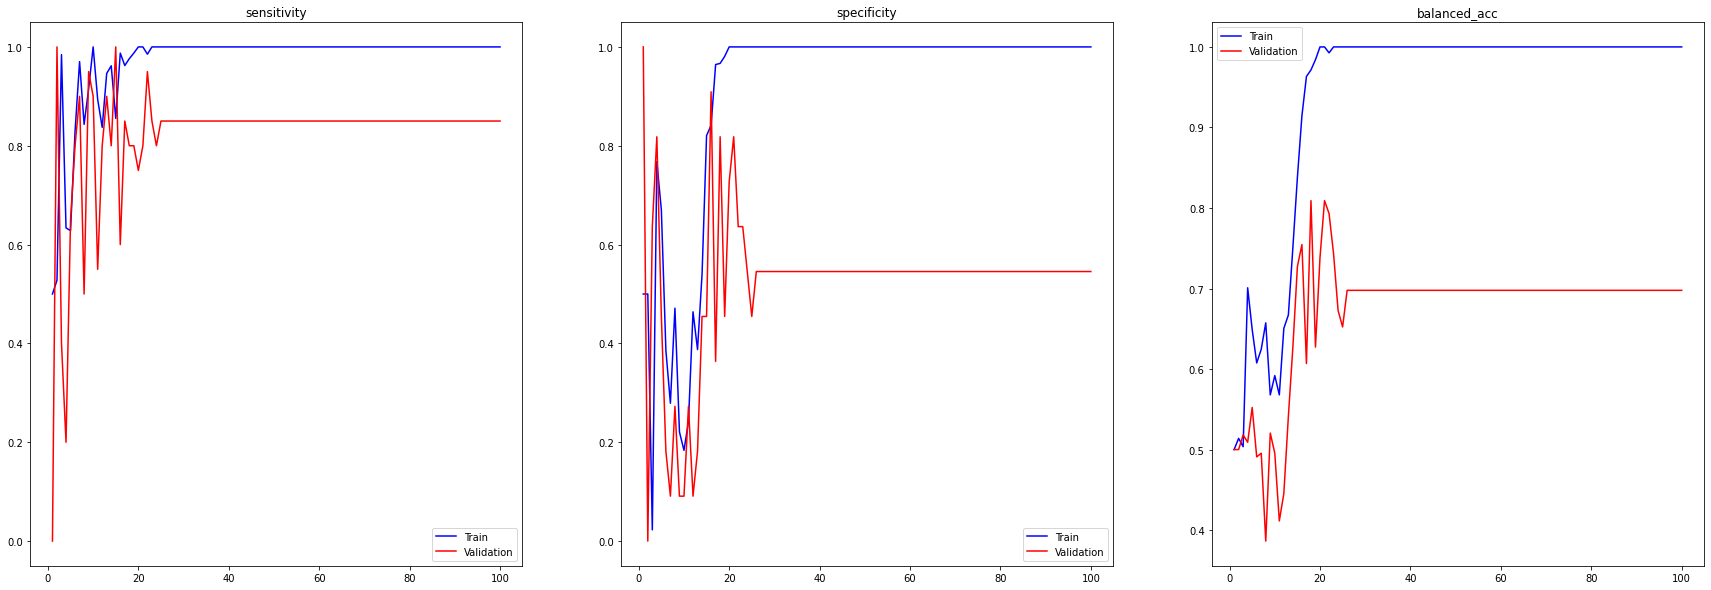

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['sensitivity', 'specificity', 'balanced_acc']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

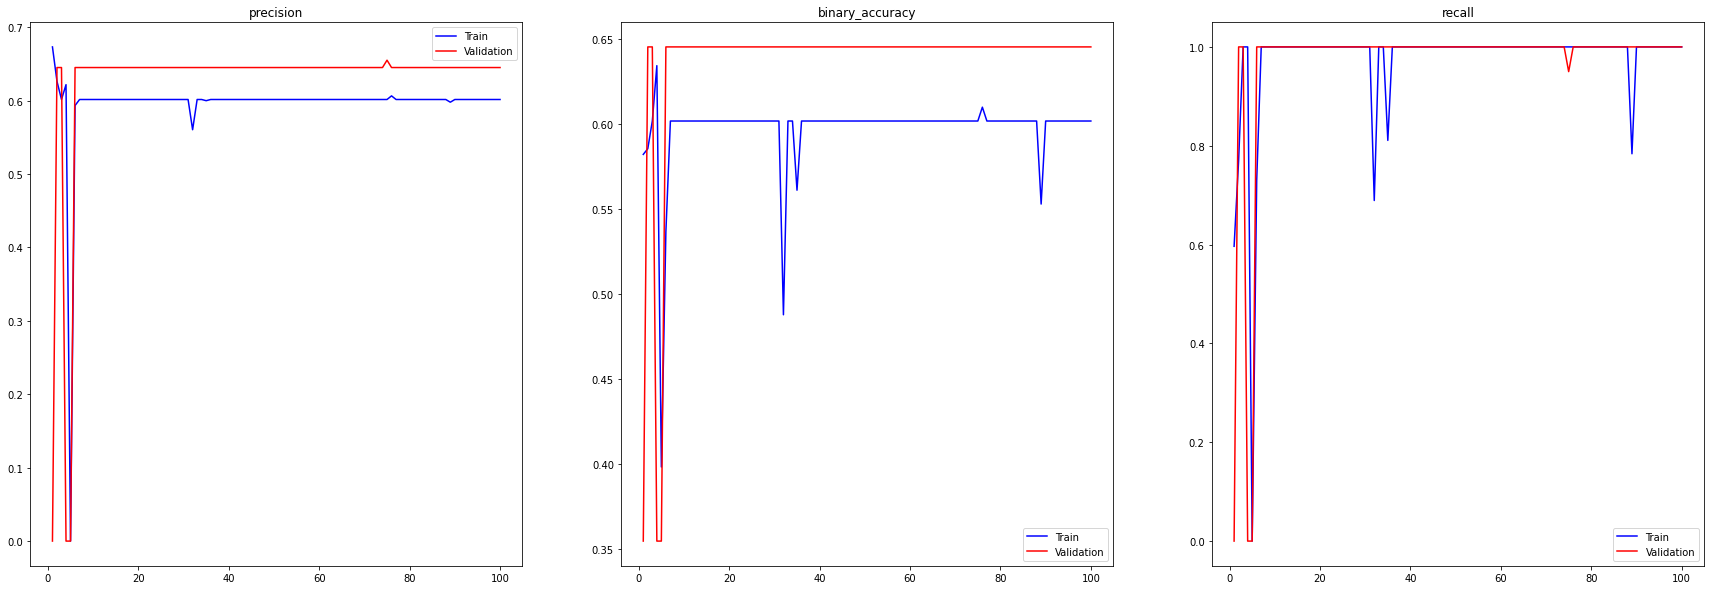

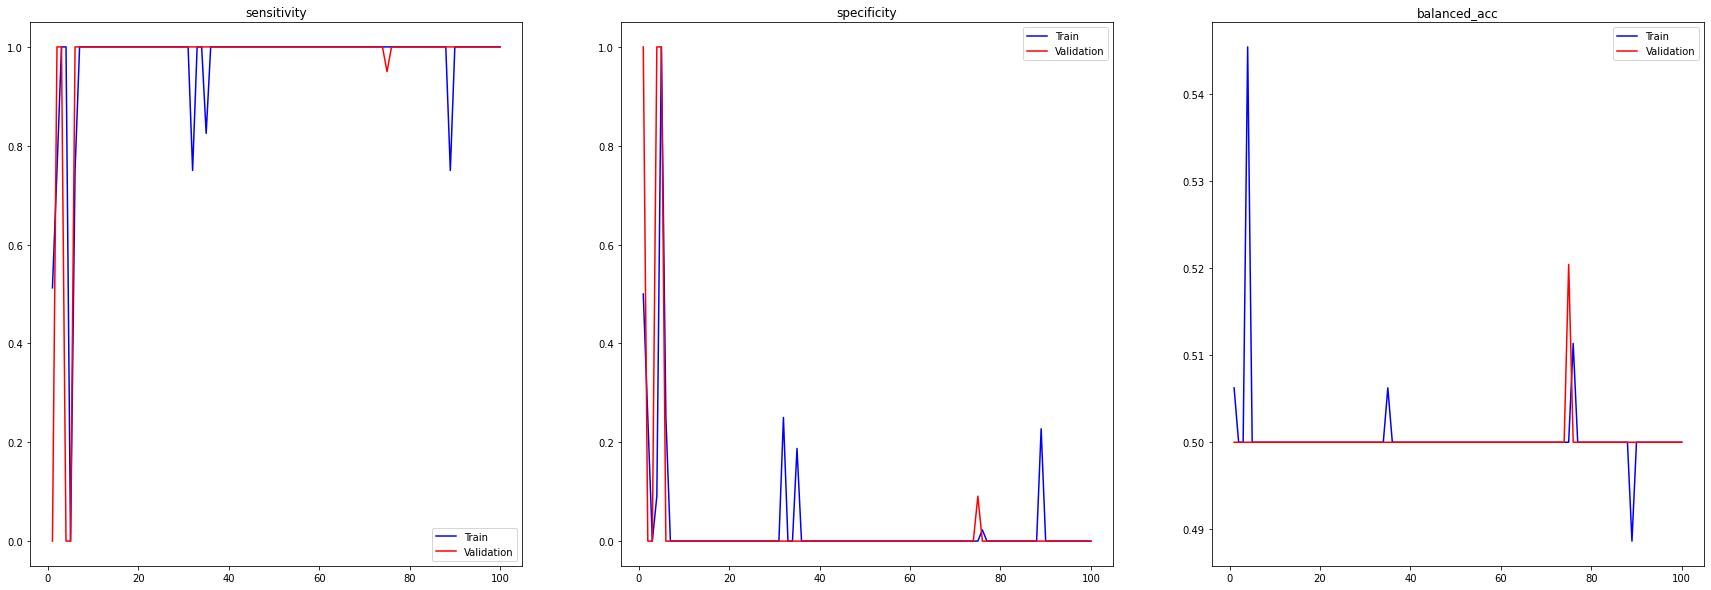

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

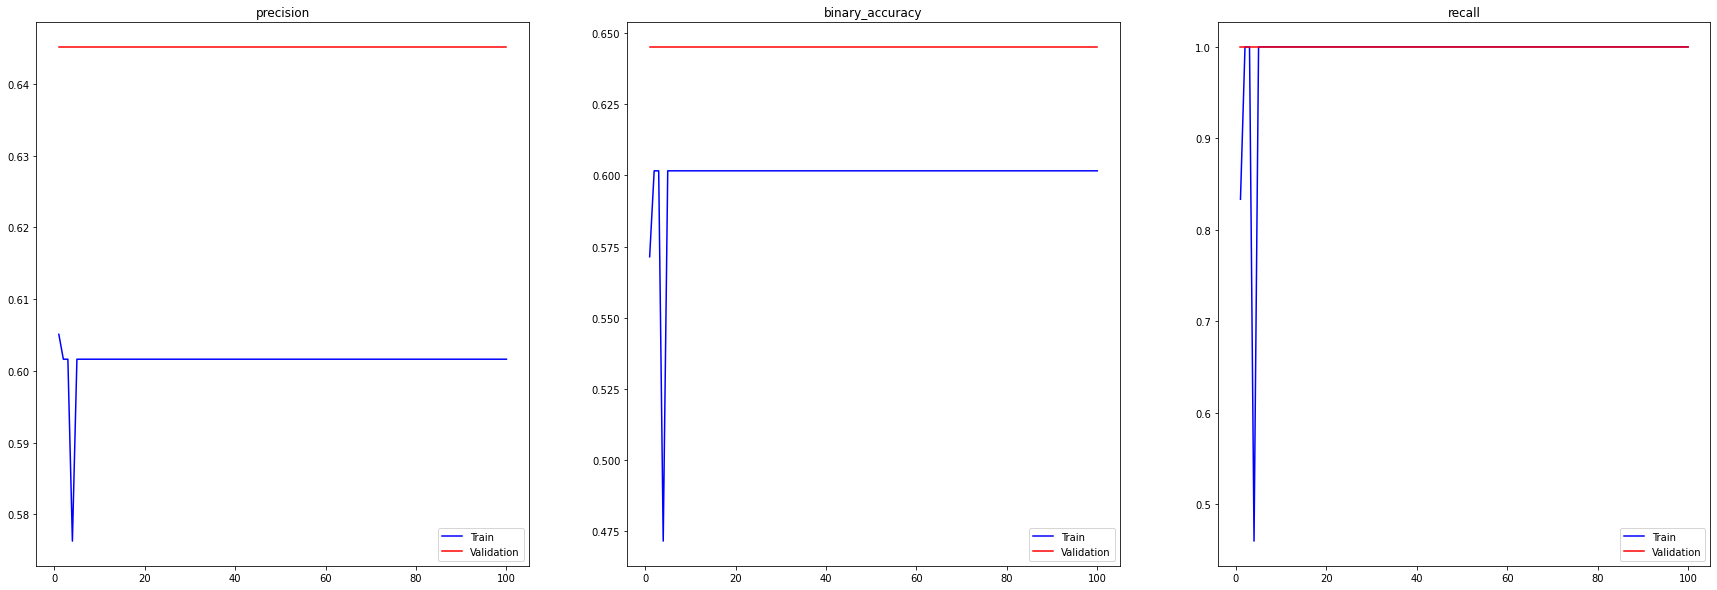

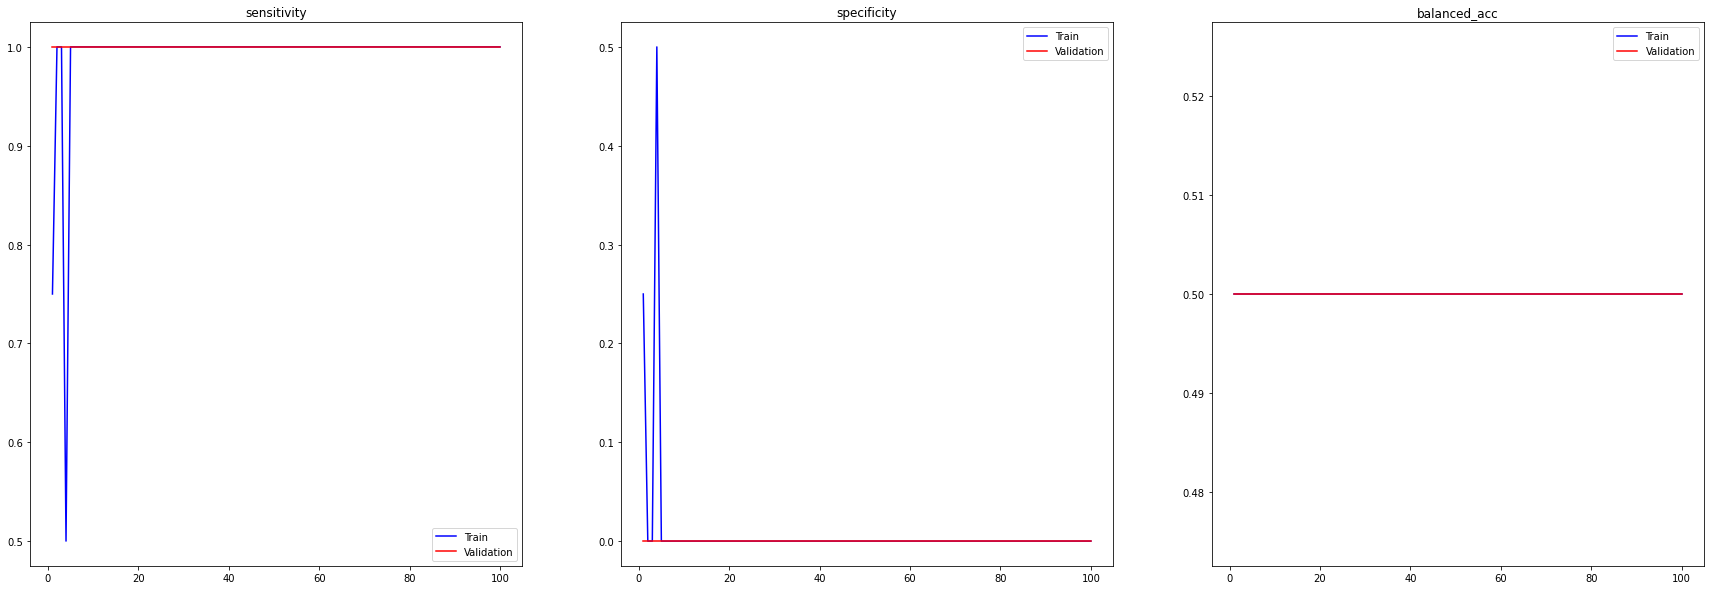

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
sensitivities, specificities = [score[4] for score in scores], [score[5] for score in scores]
baccs = [score[6] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Sensitivity':sensitivities,
    'Specificity':specificities,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Sensitivity,Specificity,Balanced Accuracy
Le-Net 5,2.717199,0.780488,0.742424,0.8,0.861742,0.775000,0.818371
VGG-16,0.670459,0.606061,0.606061,1.0,1.000000,0.333333,0.666667
Lu-Net,0.671170,0.606061,0.606061,1.0,1.000000,0.333333,0.666667


In [ ]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

## DATA AUGMENTATION

In [10]:
# X_yes, X_no, classes = load_dataset()
# X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X shape (220, 224, 224)
Num classes: 2


In [11]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

X_train, y_train = data_augmentation(X_train, y_train, 20, imgs_trans)
X_test, y_test = data_augmentation(X_test, y_test, 20, imgs_trans)
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# X_aug, y_aug = data_augmentation(X, classes, 20, imgs_trans)
# X_aug, y_aug = np.array(X_aug), np.array(y_aug)

[!] 50 images agumented...
[!] 100 images agumented...
[!] 150 images agumented...
[!] Total of 154 images augmented!

[!] 50 images agumented...
[!] Total of 66 images augmented!

X_train shape: (3080, 224, 224)
X_test shape: (1320, 224, 224)
y_train shape (3080,)
y_test shape: (1320,)


In [ ]:
# N, SIZE_H, SIZE_V = X_aug.shape
# N_CLASSES = len(np.unique(y_aug))
# print(f'X shape {X_aug.shape}')
# print(f'Num classes: {N_CLASSES}')

In [ ]:
# sd = seed(time())
# X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, random_state=sd, shuffle=True)

In [12]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, y_train, y_test)

c:\Users\kmart\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
77/77 [==============================] - 122s 2s/step - loss: 16.5933 - precision: 0.6298 - binary_accuracy: 0.6140 - recall: 0.8669 - sensitivity: 0.8621 - specificity: 0.2230 - balanced_acc: 0.5426 - val_loss: 0.6728 - val_precision: 0.6678 - val_binary_accuracy: 0.6656 - val_recall: 0.9650 - val_sensitivity: 0.8217 - val_specificity: 0.0881 - val_balanced_acc: 0.4549
Epoch 2/100
77/77 [==============================] - 115s 1s/step - loss: 0.5701 - precision: 0.7101 - binary_accuracy: 0.6989 - recall: 0.8426 - sensitivity: 0.8407 - specificity: 0.4806 - balanced_acc: 0.6607 - val_loss: 0.7083 - val_precision: 0.7068 - val_binary_accuracy: 0.6851 - val_recall: 0.8800 - val_sensitivity: 0.7224 - val_specificity: 0.1872 - val_balanced_acc: 0.4548
Epoch 3/100
77/77 [==============================] - 112s 1s/step - loss: 0.4921 - precision: 0.7780 - binary_accuracy: 0.7622 - recall: 0.8453 - sensitivity: 0.8441 - specificity: 0.6369 - balanced_acc: 0.7405 - val_loss: 0.7338 -

KeyboardInterrupt: 

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,balanced_acc,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,val_balanced_acc
0,29.677504,0.617001,0.594968,0.868280,0.871743,0.181816,0.526780,0.630212,0.629005,0.621753,0.966321,0.961785,0.043742,0.502763
1,0.616544,0.622427,0.622971,0.954973,0.955300,0.115642,0.535471,0.599797,0.662239,0.650974,0.904145,0.904891,0.252923,0.578907
2,0.571967,0.695409,0.679383,0.834677,0.832409,0.450169,0.641289,0.594657,0.726316,0.652597,0.715026,0.713124,0.556153,0.634638
3,0.531039,0.752224,0.718344,0.795699,0.796148,0.604554,0.700351,0.588395,0.748634,0.668831,0.709845,0.711449,0.608165,0.659807
4,0.469384,0.806667,0.769481,0.813172,0.810597,0.700688,0.755643,0.616786,0.747253,0.665584,0.704663,0.711979,0.613985,0.662982


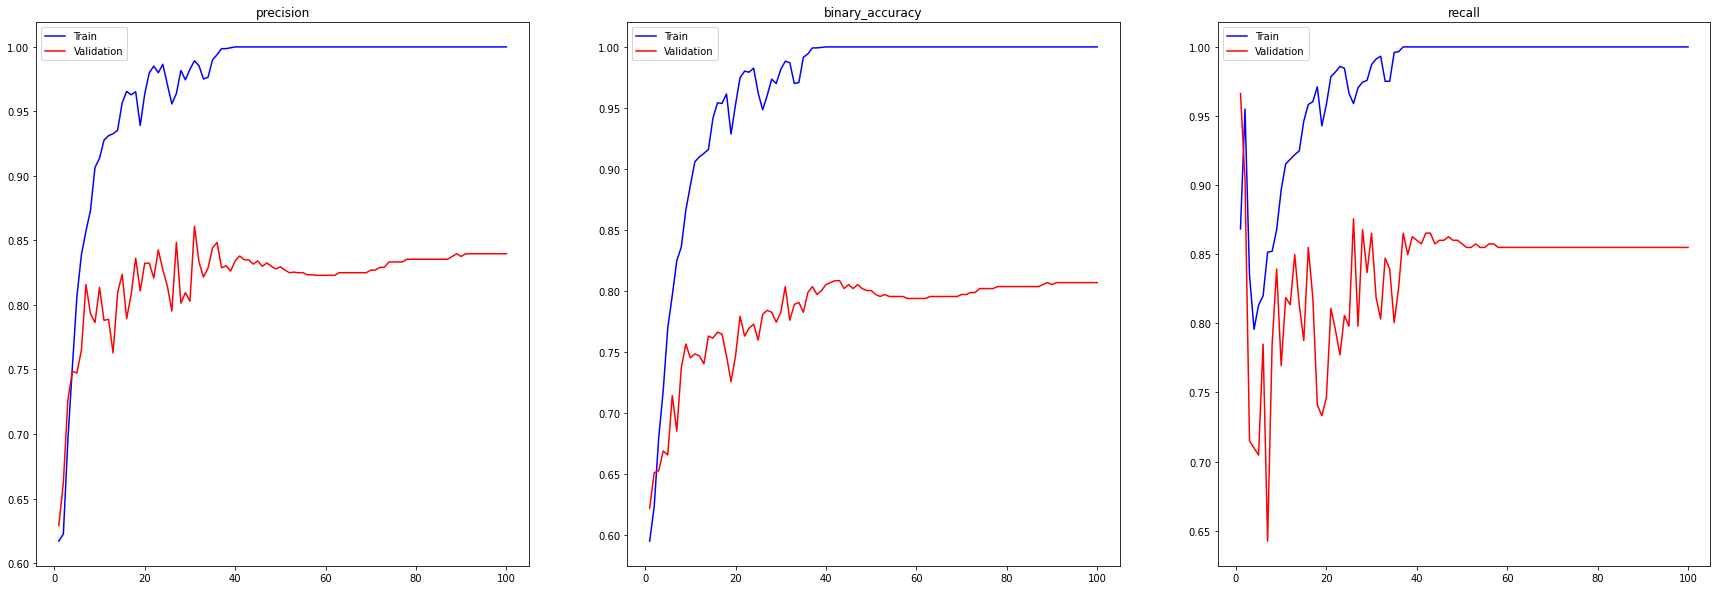

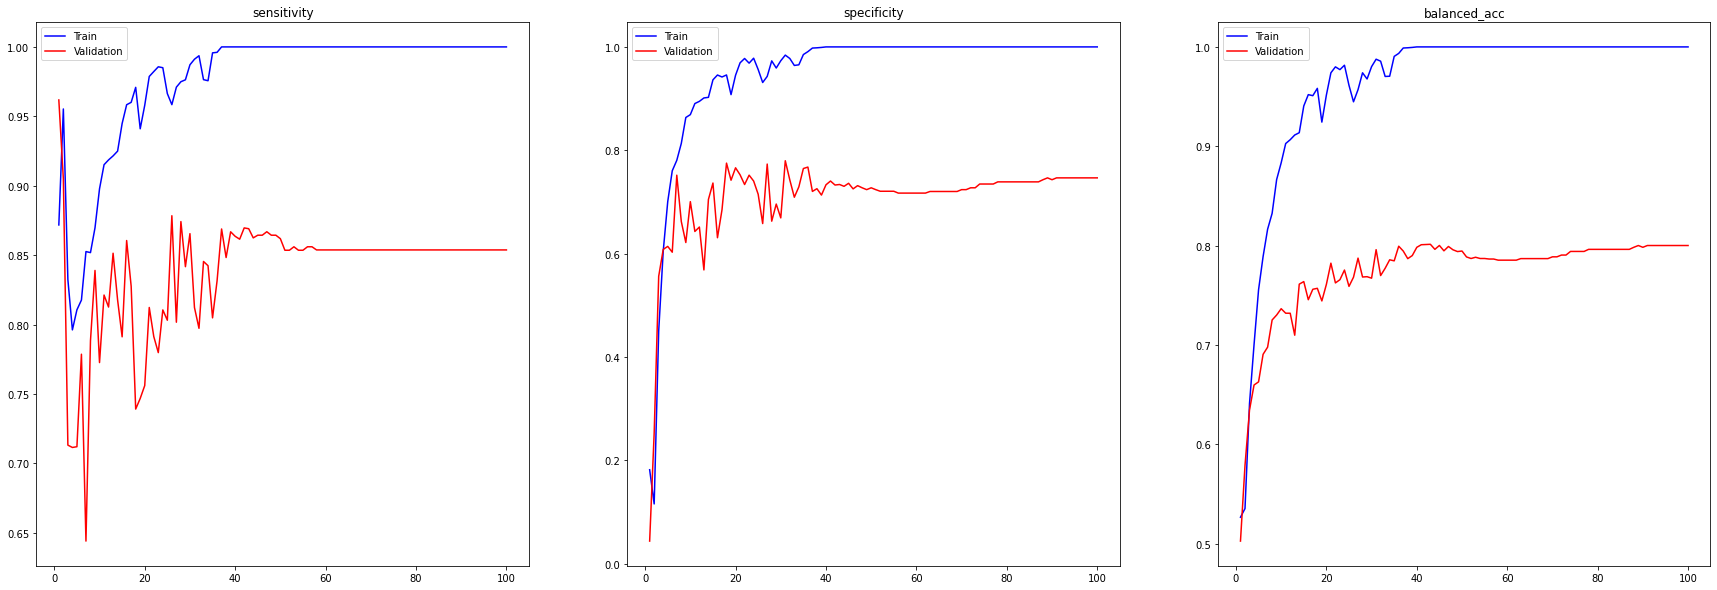

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['sensitivity', 'specificity', 'balanced_acc']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [ ]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, y_train, y_test)

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, y_train, y_test)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
sensitivities, specificities = [score[4] for score in scores], [score[5] for score in scores]
baccs = [balanced_acc(sens, spec) for sens, spec in zip(sensitivities, specificities)]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Sensitivity':sensitivities,
    'Specificity':specificities,
    'Balanced Accuracy':baccs
})
scores_df.head()

In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')